In [1]:
import torch
import torch.nn as nn
import os
import sys
import argparse
import time
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import functools
import random
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Thu Dec 23 08:08:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:1C:00.0 Off |                  N/A |
| 45%   49C    P2   167W / 350W |  12522MiB / 24268MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    On   | 00000000:69:00.0 Off |                  N/A |
| 47%   

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
class SkipConnection(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,submodule=None, outermost=False, innermost=False, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(SkipConnection, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            if output_function == nn.Tanh:
                up = [uprelu, upconv, nn.Tanh()]
            else:
                up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [5]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32,
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(Generator, self).__init__()
        # construct unet structure
        unet_block = SkipConnection(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        unet_block = SkipConnection(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer, output_function=output_function)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)

In [6]:
generator = Generator(input_nc=6, output_nc=3)
generator.load_state_dict(torch.load('checkpoints/best_e2e_w55_generator_loss.pth'))

<All keys matched successfully>

In [7]:
"""squeezenet in pytorch
[1] Song Han, Jeff Pool, John Tran, William J. Dally
    squeezenet: Learning both Weights and Connections for Efficient Neural Networks
    https://arxiv.org/abs/1506.02626
"""
class Fire(nn.Module):

    def __init__(self, in_channel, out_channel, squzee_channel):

        super().__init__()
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channel, squzee_channel, 1),
            nn.BatchNorm2d(squzee_channel),
            nn.ReLU(inplace=True)
        )

        self.expand_1x1 = nn.Sequential(
            nn.Conv2d(squzee_channel, int(out_channel / 2), 1),
            nn.BatchNorm2d(int(out_channel / 2)),
            nn.ReLU(inplace=True)
        )

        self.expand_3x3 = nn.Sequential(
            nn.Conv2d(squzee_channel, int(out_channel / 2), 3, padding=1),
            nn.BatchNorm2d(int(out_channel / 2)),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        x = self.squeeze(x)
        x = torch.cat([
            self.expand_1x1(x),
            self.expand_3x3(x)
        ], 1)

        return x

class SqueezeNet(nn.Module):

    """mobile net with simple bypass"""
    def __init__(self, class_num=100):

        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fire2 = Fire(96, 128, 16)
        self.fire3 = Fire(128, 128, 16)
        self.fire4 = Fire(128, 256, 32)
        self.fire5 = Fire(256, 256, 32)
        self.fire6 = Fire(256, 384, 48)
        self.fire7 = Fire(384, 384, 48)
        self.fire8 = Fire(384, 512, 64)
        self.fire9 = Fire(512, 512, 64)

        self.conv10 = nn.Conv2d(512, class_num, 1)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.stem(x)

        f2 = self.fire2(x)
        f3 = self.fire3(f2) + f2
        f4 = self.fire4(f3)
        f4 = self.maxpool(f4)

        f5 = self.fire5(f4) + f4
        f6 = self.fire6(f5)
        f7 = self.fire7(f6) + f6
        f8 = self.fire8(f7)
        f8 = self.maxpool(f8)

        f9 = self.fire9(f8)
        c10 = self.conv10(f9)

        x = self.avg(c10)
        x = x.view(x.size(0), -1)

        return x

def squeezenet(class_num=100):
    return SqueezeNet(class_num=class_num)

In [8]:
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [9]:
train_batch_size = 128
test_batch_size = 256


transform_train = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
#cifar100_training = CIFAR100Train(path, transform=transform_train)
cifar100_training = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
cifar100_training_loader = DataLoader(
    cifar100_training, shuffle=True, num_workers=4, batch_size=train_batch_size)

transform_test = transforms.Compose([
    transforms.ToTensor(),
])
#cifar100_test = CIFAR100Test(path, transform=transform_test)
cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
cifar100_test_loader = DataLoader(
    cifar100_test, shuffle=True, num_workers=4, batch_size=test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def show_images(images):
    grid_img = torchvision.utils.make_grid(images, nrow=3)
    plt.imshow(grid_img.permute(1,2,0))
    plt.show()

/home/nguyen.tung.thanh/anaconda3/envs/fr/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training epoch 1 - loss 3.7153396606445312


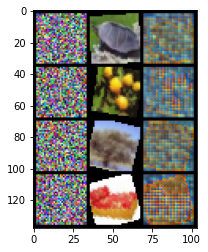

Test set: Epoch: 1, Average loss: 0.0155, Accuracy: 0.1022

saving weights file to checkpoint_cifar100/noisy_best_acc.pth


/home/nguyen.tung.thanh/anaconda3/envs/fr/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training epoch 2 - loss 3.1623260974884033


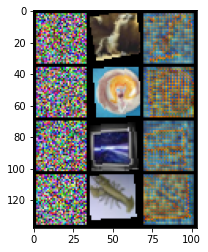

Test set: Epoch: 2, Average loss: 0.0142, Accuracy: 0.1717

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 3 - loss 2.634460210800171


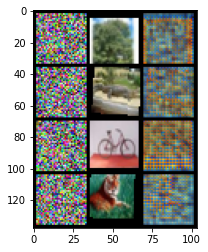

Test set: Epoch: 3, Average loss: 0.0178, Accuracy: 0.1285

Training epoch 4 - loss 2.826894521713257


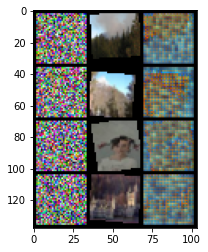

Test set: Epoch: 4, Average loss: 0.0121, Accuracy: 0.2461

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 5 - loss 2.4333252906799316


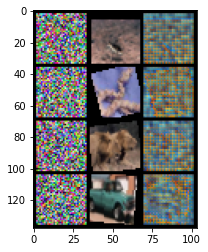

Test set: Epoch: 5, Average loss: 0.0126, Accuracy: 0.2578

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 6 - loss 2.3284878730773926


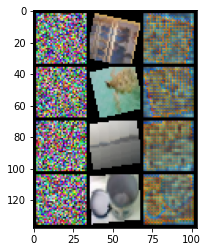

Test set: Epoch: 6, Average loss: 0.0126, Accuracy: 0.2600

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 7 - loss 2.224438190460205


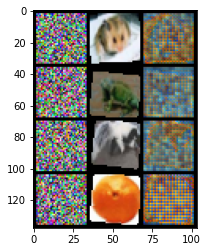

Test set: Epoch: 7, Average loss: 0.0112, Accuracy: 0.3105

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 8 - loss 2.3055520057678223


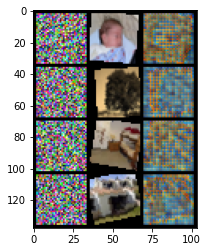

Test set: Epoch: 8, Average loss: 0.0114, Accuracy: 0.3171

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 9 - loss 2.419081211090088


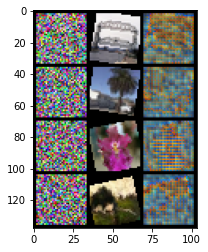

Test set: Epoch: 9, Average loss: 0.0128, Accuracy: 0.2655

Training epoch 10 - loss 2.4178709983825684


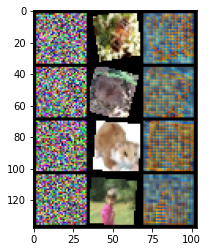

Test set: Epoch: 10, Average loss: 0.0135, Accuracy: 0.2223

Training epoch 11 - loss 1.9280287027359009


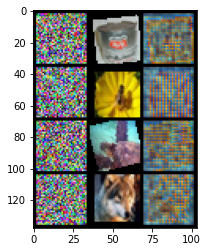

Test set: Epoch: 11, Average loss: 0.0092, Accuracy: 0.3985

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 12 - loss 2.28712797164917


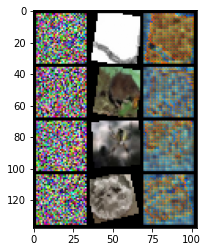

Test set: Epoch: 12, Average loss: 0.0109, Accuracy: 0.3447

Training epoch 13 - loss 1.9370990991592407


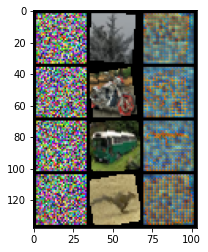

Test set: Epoch: 13, Average loss: 0.0114, Accuracy: 0.3187

Training epoch 14 - loss 2.0700926780700684


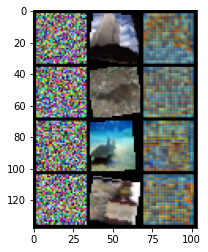

Test set: Epoch: 14, Average loss: 0.0095, Accuracy: 0.3916

Training epoch 15 - loss 2.117994785308838


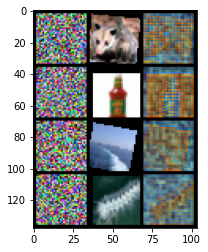

Test set: Epoch: 15, Average loss: 0.0097, Accuracy: 0.3883

Training epoch 16 - loss 2.495307445526123


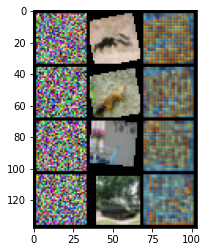

Test set: Epoch: 16, Average loss: 0.0097, Accuracy: 0.3768

Training epoch 17 - loss 1.9465385675430298


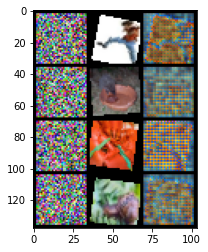

Test set: Epoch: 17, Average loss: 0.0094, Accuracy: 0.4006

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 18 - loss 2.092439651489258


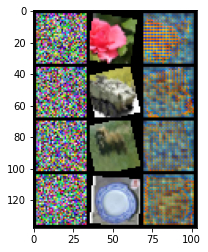

Test set: Epoch: 18, Average loss: 0.0112, Accuracy: 0.3226

Training epoch 19 - loss 2.114496946334839


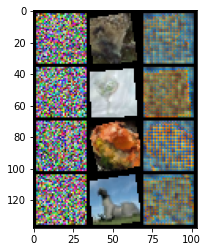

Test set: Epoch: 19, Average loss: 0.0113, Accuracy: 0.3150

Training epoch 20 - loss 2.1172072887420654


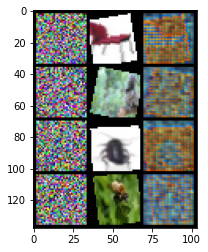

Test set: Epoch: 20, Average loss: 0.0101, Accuracy: 0.3628

Training epoch 21 - loss 1.6918036937713623


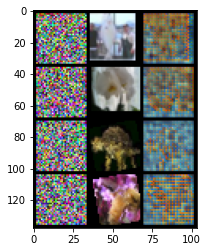

Test set: Epoch: 21, Average loss: 0.0105, Accuracy: 0.3695

Training epoch 22 - loss 2.112440824508667


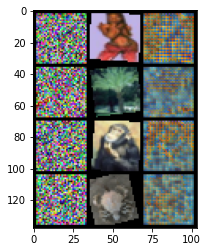

Test set: Epoch: 22, Average loss: 0.0104, Accuracy: 0.3804

Training epoch 23 - loss 2.1379289627075195


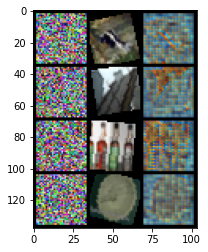

Test set: Epoch: 23, Average loss: 0.0089, Accuracy: 0.4227

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 24 - loss 1.7277772426605225


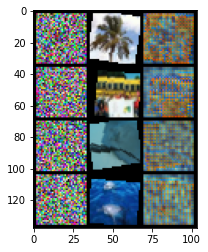

Test set: Epoch: 24, Average loss: 0.0094, Accuracy: 0.4020

Training epoch 25 - loss 2.3505024909973145


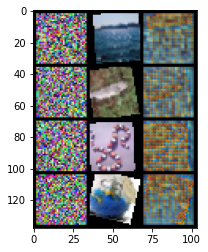

Test set: Epoch: 25, Average loss: 0.0095, Accuracy: 0.4076

Training epoch 26 - loss 1.9712079763412476


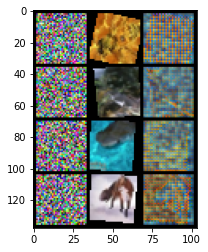

Test set: Epoch: 26, Average loss: 0.0109, Accuracy: 0.3494

Training epoch 27 - loss 1.8892278671264648


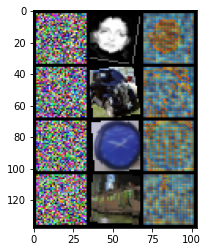

Test set: Epoch: 27, Average loss: 0.0095, Accuracy: 0.4120

Training epoch 28 - loss 1.9231350421905518


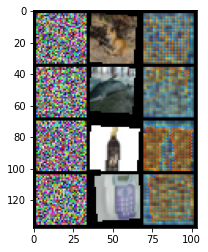

Test set: Epoch: 28, Average loss: 0.0089, Accuracy: 0.4227

Training epoch 29 - loss 2.0637660026550293


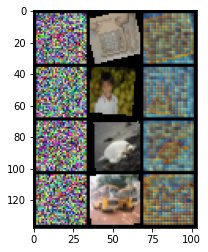

Test set: Epoch: 29, Average loss: 0.0096, Accuracy: 0.3895

Training epoch 30 - loss 1.9889285564422607


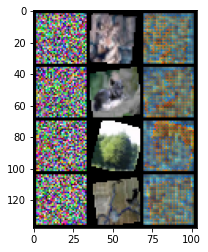

Test set: Epoch: 30, Average loss: 0.0089, Accuracy: 0.4277

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 31 - loss 1.6128135919570923


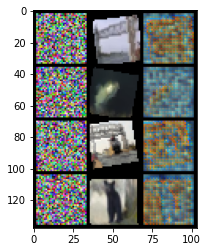

Test set: Epoch: 31, Average loss: 0.0083, Accuracy: 0.4585

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 32 - loss 1.731452226638794


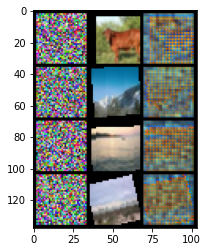

Test set: Epoch: 32, Average loss: 0.0099, Accuracy: 0.3933

Training epoch 33 - loss 1.9089921712875366


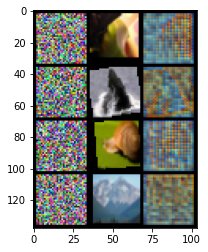

Test set: Epoch: 33, Average loss: 0.0102, Accuracy: 0.3639

Training epoch 34 - loss 1.8180735111236572


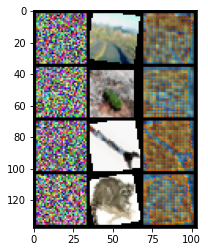

Test set: Epoch: 34, Average loss: 0.0129, Accuracy: 0.3125

Training epoch 35 - loss 1.9363043308258057


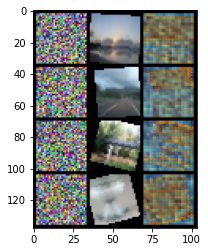

Test set: Epoch: 35, Average loss: 0.0089, Accuracy: 0.4269

Training epoch 36 - loss 2.01700496673584


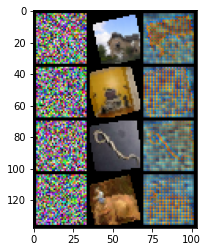

Test set: Epoch: 36, Average loss: 0.0096, Accuracy: 0.4036

Training epoch 37 - loss 1.7394956350326538


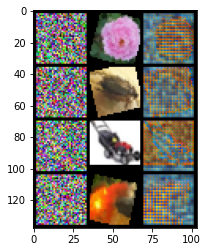

Test set: Epoch: 37, Average loss: 0.0105, Accuracy: 0.3816

Training epoch 38 - loss 1.9785897731781006


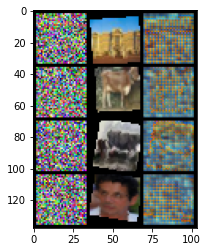

Test set: Epoch: 38, Average loss: 0.0118, Accuracy: 0.3016

Training epoch 39 - loss 2.0141239166259766


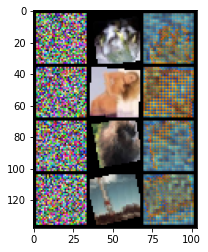

Test set: Epoch: 39, Average loss: 0.0101, Accuracy: 0.3813

Training epoch 40 - loss 1.8234407901763916


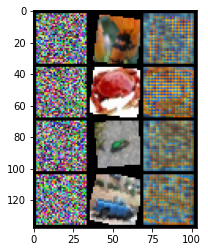

Test set: Epoch: 40, Average loss: 0.0086, Accuracy: 0.4400

Training epoch 41 - loss 2.0707061290740967


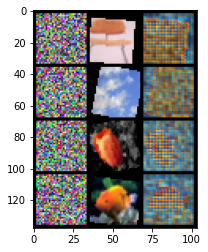

Test set: Epoch: 41, Average loss: 0.0101, Accuracy: 0.3949

Training epoch 42 - loss 1.8842964172363281


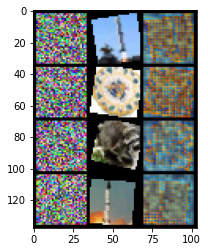

Test set: Epoch: 42, Average loss: 0.0094, Accuracy: 0.4252

Training epoch 43 - loss 1.9629018306732178


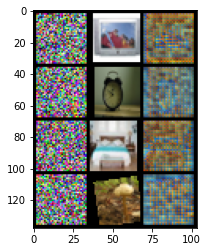

Test set: Epoch: 43, Average loss: 0.0103, Accuracy: 0.3666

Training epoch 44 - loss 1.8047873973846436


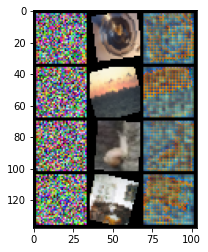

Test set: Epoch: 44, Average loss: 0.0087, Accuracy: 0.4441

Training epoch 45 - loss 1.9541492462158203


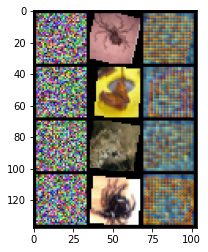

Test set: Epoch: 45, Average loss: 0.0086, Accuracy: 0.4401

Training epoch 46 - loss 1.9447710514068604


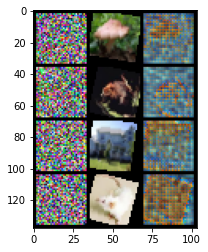

Test set: Epoch: 46, Average loss: 0.0107, Accuracy: 0.3656

Training epoch 47 - loss 1.9761625528335571


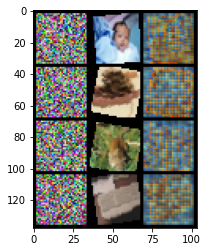

Test set: Epoch: 47, Average loss: 0.0084, Accuracy: 0.4496

Training epoch 48 - loss 1.7977949380874634


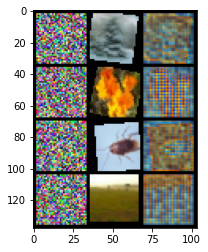

Test set: Epoch: 48, Average loss: 0.0093, Accuracy: 0.4152

Training epoch 49 - loss 1.6816434860229492


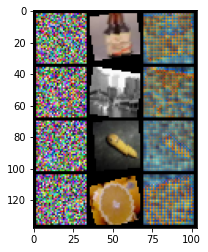

Test set: Epoch: 49, Average loss: 0.0094, Accuracy: 0.4095

Training epoch 50 - loss 2.0420966148376465


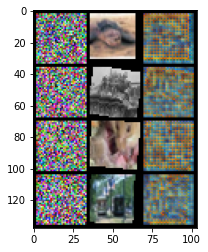

Test set: Epoch: 50, Average loss: 0.0089, Accuracy: 0.4248

Training epoch 51 - loss 1.8252098560333252


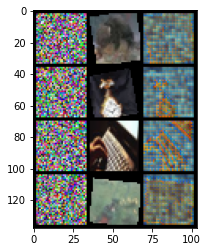

Test set: Epoch: 51, Average loss: 0.0085, Accuracy: 0.4413

Training epoch 52 - loss 1.8983055353164673


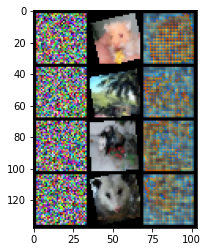

Test set: Epoch: 52, Average loss: 0.0082, Accuracy: 0.4612

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 53 - loss 1.8836688995361328


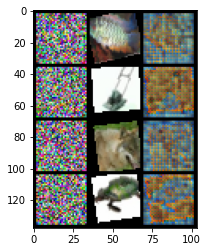

Test set: Epoch: 53, Average loss: 0.0090, Accuracy: 0.4141

Training epoch 54 - loss 2.012880802154541


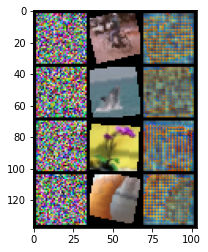

Test set: Epoch: 54, Average loss: 0.0095, Accuracy: 0.4153

Training epoch 55 - loss 1.8992459774017334


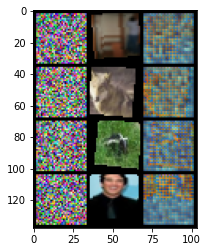

Test set: Epoch: 55, Average loss: 0.0087, Accuracy: 0.4449

Training epoch 56 - loss 1.9880024194717407


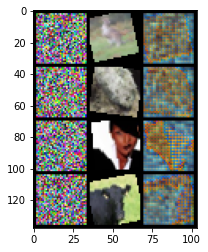

Test set: Epoch: 56, Average loss: 0.0091, Accuracy: 0.4223

Training epoch 57 - loss 1.8693040609359741


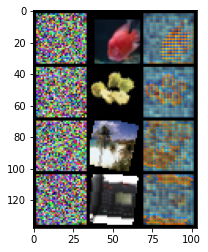

Test set: Epoch: 57, Average loss: 0.0098, Accuracy: 0.4004

Training epoch 58 - loss 1.809969186782837


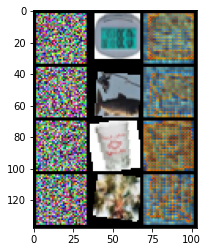

Test set: Epoch: 58, Average loss: 0.0135, Accuracy: 0.2812

Training epoch 59 - loss 1.8607447147369385


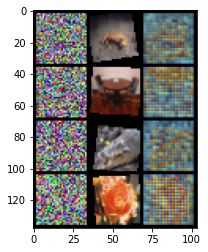

Test set: Epoch: 59, Average loss: 0.0085, Accuracy: 0.4446

Training epoch 60 - loss 1.430986762046814


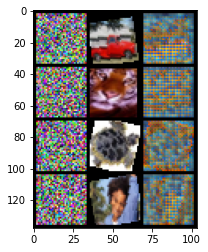

Test set: Epoch: 60, Average loss: 0.0059, Accuracy: 0.5843

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 61 - loss 1.4741499423980713


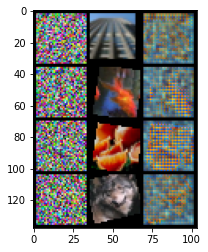

Test set: Epoch: 61, Average loss: 0.0058, Accuracy: 0.5918

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 62 - loss 1.2525527477264404


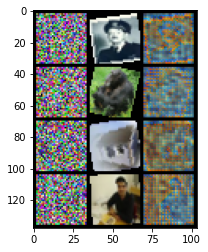

Test set: Epoch: 62, Average loss: 0.0058, Accuracy: 0.5980

saving weights file to checkpoint_cifar100/noisy_best_acc.pth
Training epoch 63 - loss 1.2369955778121948


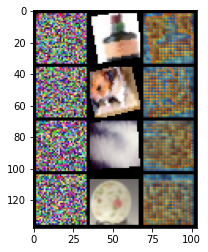

Test set: Epoch: 63, Average loss: 0.0061, Accuracy: 0.5838

Training epoch 64 - loss 1.4179444313049316


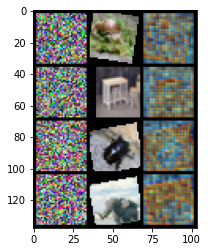

Test set: Epoch: 64, Average loss: 0.0060, Accuracy: 0.5974

Training epoch 65 - loss 1.2803380489349365


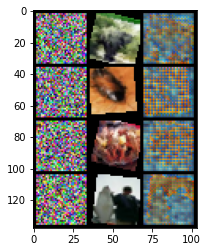

Test set: Epoch: 65, Average loss: 0.0060, Accuracy: 0.5931

Training epoch 66 - loss 1.315312385559082


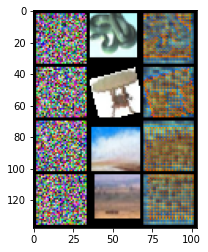

Test set: Epoch: 66, Average loss: 0.0061, Accuracy: 0.5817

Training epoch 67 - loss 1.3558640480041504


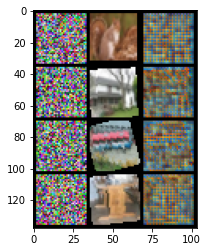

Test set: Epoch: 67, Average loss: 0.0061, Accuracy: 0.5869

Training epoch 68 - loss 1.3710520267486572


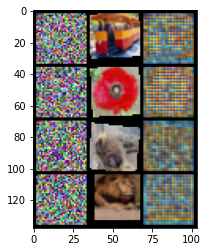

Test set: Epoch: 68, Average loss: 0.0062, Accuracy: 0.5801

Training epoch 69 - loss 1.4708703756332397


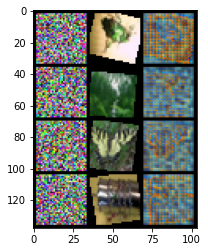

Test set: Epoch: 69, Average loss: 0.0063, Accuracy: 0.5727

Training epoch 70 - loss 1.4443278312683105


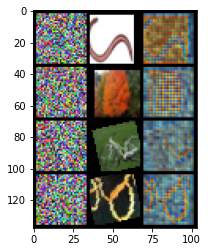

Test set: Epoch: 70, Average loss: 0.0066, Accuracy: 0.5603

Training epoch 71 - loss 1.3490339517593384


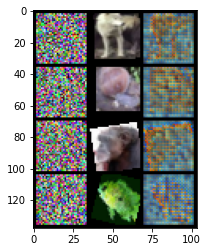

Test set: Epoch: 71, Average loss: 0.0064, Accuracy: 0.5705

Training epoch 72 - loss 1.134432077407837


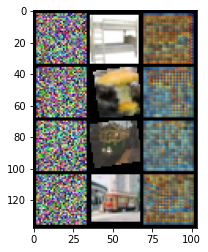

Test set: Epoch: 72, Average loss: 0.0063, Accuracy: 0.5773

Training epoch 73 - loss 1.3767929077148438


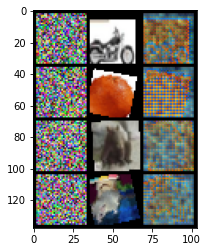

Test set: Epoch: 73, Average loss: 0.0064, Accuracy: 0.5677

Training epoch 74 - loss 1.3429696559906006


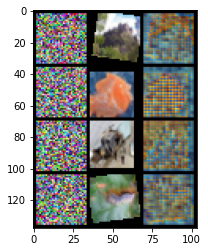

Test set: Epoch: 74, Average loss: 0.0061, Accuracy: 0.5867

Training epoch 75 - loss 1.23604416847229


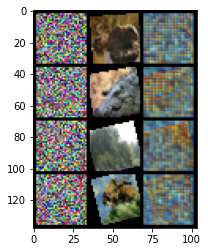

Test set: Epoch: 75, Average loss: 0.0063, Accuracy: 0.5744

Training epoch 76 - loss 1.449224591255188


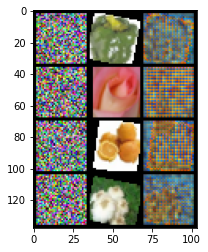

Test set: Epoch: 76, Average loss: 0.0065, Accuracy: 0.5561

Training epoch 77 - loss 1.2417272329330444


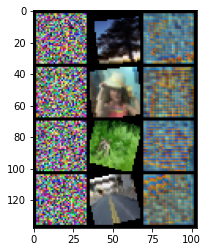

Test set: Epoch: 77, Average loss: 0.0066, Accuracy: 0.5602



In [ ]:
# train.py
#!/usr/bin/env	python3

""" train network using pytorch
author baiyu
"""
generator.cuda()
def train(epoch):
    net.train()
    output_images = []
    for batch_index, (images, labels) in enumerate(cifar100_training_loader):
        pivot = len(images)
        labels = labels.cuda()
        images = images.cuda()
        container = []
#         container = torch.zeros(images.shape).cuda()
        for i in range(len(images)):
            seed = int(images[i].sum().item()*255)
            torch.manual_seed(seed)
            c = torch.randint(0, 255, images.shape[1:]).cuda() / 255.0
            container.append(c)
        container = torch.stack(container)
        generator_input = torch.cat([container, images], dim=1)
        privacy_images = generator(generator_input)
        
        if batch_index % 100 == 0:
            index = random.randint(0, pivot - 1)
            output_images.extend([container[index].cpu(), images[index].cpu(), privacy_images[index].cpu()])

        optimizer.zero_grad()
        outputs = net(privacy_images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        if epoch <= 1:
            warmup_scheduler.step()
    print('Training epoch {} - loss {}'.format(epoch, loss.item()))

    show_images(output_images)

@torch.no_grad()
def eval_training(epoch=0, tb=True):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0

    for (images, labels) in cifar100_test_loader:

        images = images.cuda()
        labels = labels.cuda()
        container = []
#         container = torch.zeros(images.shape).cuda()
        for i in range(len(images)):
            seed = int(images[i].sum().item()*255)
            torch.manual_seed(seed)
            c = torch.randint(0, 255, images.shape[1:]).cuda() / 255.0
            container.append(c)
        container = torch.stack(container)
        generator_input = torch.cat([container, images], dim=1)
        privacy_images = generator(generator_input)

        outputs = net(privacy_images)
        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()
    
    print('Test set: Epoch: {}, Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        epoch,
        test_loss / len(cifar100_test_loader.dataset),
        correct.float() / len(cifar100_test_loader.dataset)
    ))
    print()

    return correct.float() / len(cifar100_test_loader.dataset)

if __name__ == '__main__':

    net = squeezenet().cuda()

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    iter_per_epoch = len(cifar100_training_loader)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * 1)

    checkpoint_path = 'checkpoint_cifar100'
    
    #create checkpoint folder to save model
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_path = os.path.join(checkpoint_path, '{net}-{epoch}-{type}.pth')

    best_acc = 0.0

    for epoch in range(1, 200 + 1):
        if epoch > 1:
            train_scheduler.step(epoch)

        train(epoch)
        acc = eval_training(epoch)

        #start to save best performance model after learning rate decay to 0.01
        if best_acc < acc:
            weights_path = 'checkpoint_cifar100/noisy_best_acc.pth'
            print('saving weights file to {}'.format(weights_path))
            torch.save(net.state_dict(), weights_path)
            best_acc = acc

In [ ]:
import torch

In [ ]:
!nvidia-smi

In [ ]:
torch.manual_seed(23)
a = torch.randint(0, 255, (32, 32))
torch.manual_seed(23)
b = torch.randint(0, 255, (32, 32))
torch.manual_seed(23)
c = torch.randint(0, 255, (32, 32))
d = torch.randint(0, 255, (32, 32))

In [ ]:
a == b

In [ ]:
c == a

In [ ]:
c == d

In [ ]:
l = [a, b, c]

In [ ]:
con = torch.stack(l, dim=0)

In [ ]:
con.shape